**Step 1: GPU configuration**

In [22]:
%%time
# Step 1: GPU configuration
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found
CPU times: user 7.67 ms, sys: 885 µs, total: 8.56 ms
Wall time: 111 ms


**Step 2: Mount Google Drive**

In [23]:
# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 3: Install required packages**

In [24]:
!pip install tensorflow_addons
!pip install visualkeras
!pip install -U tensorflow-addons


**Step 4: Import libraries**

In [25]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

import warnings
import pandas as pd
from sklearn.utils import class_weight
from collections import Counter

warnings.filterwarnings('ignore')
%matplotlib inline

**Step 5: Define labels and image size**

In [26]:
labels = ["Cucumber Mosaic Virus", "Downy Mildew", "Leaf Spot"]
img_size = 32

**Step 6: Function to get data**

In [27]:
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


**Step 7: Load data**

In [28]:
data_dir = get_data("/content/drive/MyDrive/Luffa Aegyptiaca 480")

**Step 8: Display total number of training images**

In [29]:
image_names = glob.glob(os.path.join('/content/drive/MyDrive/Luffa Aegyptiaca 480', '*', '*'))
print("Total number of training images: ", len(image_names))

Total number of training images:  6533


**Step 9: Create a DataFrame with Filename and ClassId**

In [30]:
data_df = pd.DataFrame()
data_df['Filename'] = [img_name.split("/")[-1] for img_name in image_names]
data_df['ClassId'] = [img_name.split("/")[-2] for img_name in image_names]


**Step 10: Display sample images**

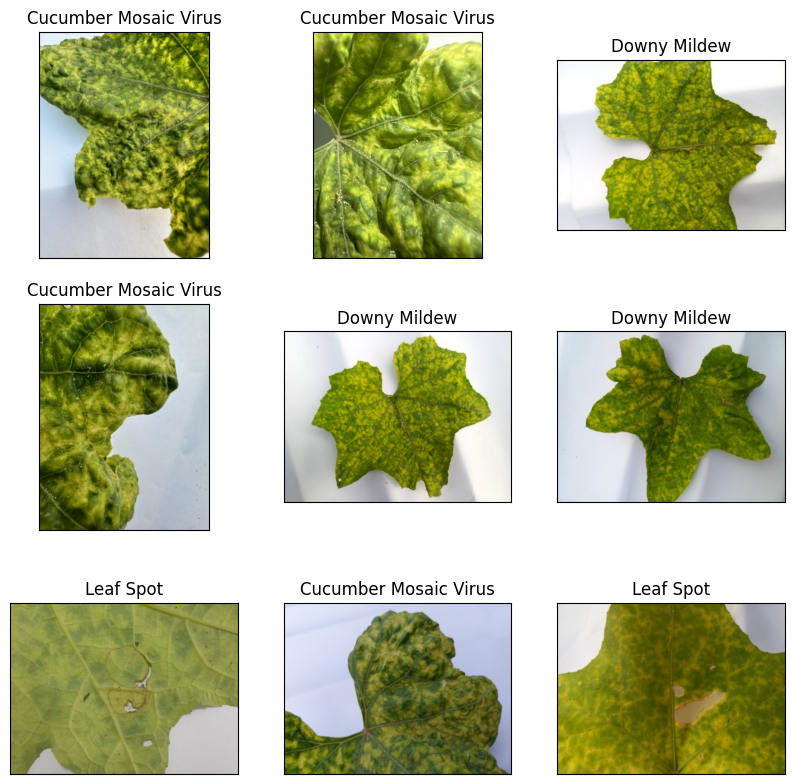

In [31]:
plot_df = data_df.sample(min(9, len(data_df))).reset_index()
plt.figure(figsize=(10, 10))
for i in range(9):
    img_name = plot_df.loc[i, 'Filename']
    label_str = (plot_df.loc[i, 'ClassId'])
    plt.subplot(3, 3, i+1)
    plt.imshow(plt.imread(os.path.join('/content/drive/MyDrive/Luffa Aegyptiaca 480', label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])


**Step 11: Display class distribution**

<BarContainer object of 3 artists>

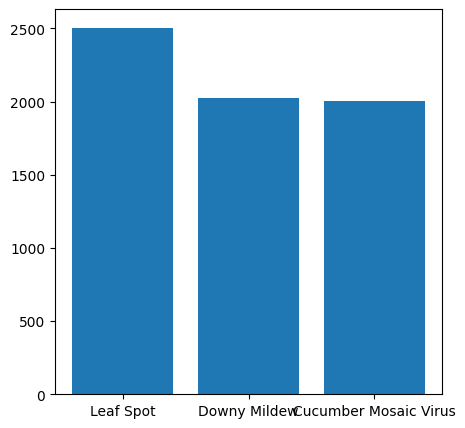

In [32]:
class_id_distribution = data_df['ClassId'].value_counts()
plt.figure(figsize=(5,5))
plt.xticks(np.arange(43))
plt.bar(class_id_distribution.index, class_id_distribution.values)


**Step 12: Preprocess and split data**

In [33]:
X = []
Y = []
for feature, label in data_dir:
  X.append(feature)
  Y.append(label)
X = np.array(X) / 255
X.reshape(-1, img_size, img_size, 1)
Y = np.array(Y)


**Step 13: Split data with stratified sampling**

In [34]:
# Make sure to import train_test_split
from sklearn.model_selection import train_test_split

# Split data with stratified sampling
(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.10, stratify=Y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.18, random_state=8)


**Step 14: Display shapes of train, validation, and test sets**

In [35]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (4820, 32, 32, 3) - y_train shape: (4820,)
x_val shape: (1059, 32, 32, 3) - y_val shape: (1059,)
x_test shape: (654, 32, 32, 3) - y_test shape: (654,)


**Step 16: Set up model parameters**

In [36]:
num_classes = 3
input_shape = (32, 32, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 250


**Step 17: Data augmentation**

In [37]:
# Make sure to import layers
from keras import layers

# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(img_size, img_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)


**Step 18: Define CNN model**

In [38]:
def create_cnn_classifier():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPool2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPool2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPool2D(2,2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


**Step 19: Display CNN model summary**

In [39]:
cnn_classifier = create_cnn_classifier()
cnn_classifier.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 128)        

**Step 20: Compile CNN model**

In [40]:
initial_learning_rate = learning_rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=weight_decay, staircase=True
)

cnn_classifier.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


**Step 21: Run CNN experiment**

In [41]:
# Define early stopping callback
early_stopping_cnn = tf.keras.callbacks.EarlyStopping(
    patience=15,
    verbose=1,
    mode='auto'
)


In [ ]:
# Step x: Define CNN

def run_cnn_experiment(model, early_stopping):
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping]
    )
    return history

**Step 22: Create and run CNN model**

In [43]:
# Run CNN experiment
cnn_history = run_cnn_experiment(cnn_classifier, early_stopping_cnn)


NameError: ignored

**Step 23: Plot training and validation metrics**

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


**Step 24: Evaluate CNN model on validation set**

In [ ]:
cnn_predictions = cnn_classifier.predict(x_val)
cnn_y_pred = [np.argmax(probas) for probas in cnn_predictions]


**Step 25: Plot normalized confusion matrix for validation set**

In [ ]:
import itertools  # Make sure to import itertools

# Define a function to plot confusion matrix based on support
def plot_confusion_matrix_support(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization is applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    cm_support = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalization by support

    thresh = cm_support.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm_support[i, j]),
                 horizontalalignment="center",
                 color="white" if cm_support[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot normalized confusion matrix for validation set based on support
plt.figure()
plot_confusion_matrix_support(cnf_matrix_cnn, classes=labels, title='Normalized confusion matrix (CNN)')
plt.show()



**Step 26: Display classification report for validation set**

In [ ]:
print(classification_report(y_val, cnn_y_pred, target_names=labels))


**Step 27: Evaluate CNN model on test set**

In [ ]:
cnn_predictions_test = cnn_classifier.predict(x_test)
cnn_y_pred_test = [np.argmax(probas) for probas in cnn_predictions_test]


**Step 28: Plot normalized confusion matrix for test set**

In [ ]:
# Define a function to plot confusion matrix based on support
def plot_confusion_matrix_support(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization is applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    cm_support = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalization by support

    thresh = cm_support.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm_support[i, j]),
                 horizontalalignment="center",
                 color="white" if cm_support[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot normalized confusion matrix for test set based on support
plt.figure()
plot_confusion_matrix_support(cnf_matrix_cnn_test, classes=labels, title='Normalized confusion matrix (CNN - Test)')
plt.show()


**Step 29: Display classification report for test set**

In [ ]:
print(classification_report(y_test, cnn_y_pred_test, target_names=labels))
